100%|██████████| 1032/1032 [1:13:50<00:00,  4.29s/it]


Epoch [0], val_loss: 0.3436, val_acc: 0.8860


100%|██████████| 1032/1032 [1:18:27<00:00,  4.56s/it]


Epoch [1], val_loss: 0.1066, val_acc: 0.9643


100%|██████████| 1032/1032 [1:16:50<00:00,  4.47s/it]


Epoch [2], val_loss: 0.0508, val_acc: 0.9854


100%|██████████| 1032/1032 [1:17:40<00:00,  4.52s/it]


Epoch [3], val_loss: 0.0441, val_acc: 0.9860


100%|██████████| 1032/1032 [1:17:58<00:00,  4.53s/it]


Epoch [4], val_loss: 0.0267, val_acc: 0.9919


100%|██████████| 1032/1032 [1:03:14<00:00,  3.68s/it]


Epoch [5], val_loss: 0.0227, val_acc: 0.9926


100%|██████████| 1032/1032 [42:27<00:00,  2.47s/it]


Epoch [6], val_loss: 0.0184, val_acc: 0.9949


100%|██████████| 1032/1032 [42:24<00:00,  2.47s/it]


Epoch [7], val_loss: 0.0163, val_acc: 0.9956


100%|██████████| 1032/1032 [41:49<00:00,  2.43s/it]


Epoch [8], val_loss: 0.0460, val_acc: 0.9857


100%|██████████| 1032/1032 [41:32<00:00,  2.41s/it]


Epoch [9], val_loss: 0.0141, val_acc: 0.9955


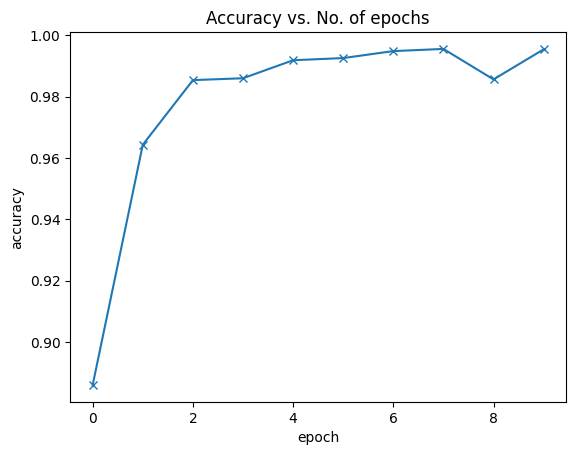

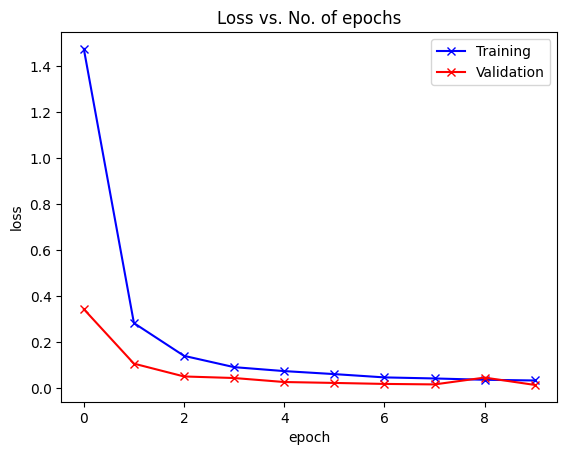

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Custom Image Classification Base Class
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["val_loss"], result["val_acc"]
            )
        )


# Custom AlexNet Class
class AlexNet(ImageClassificationBase):
    def __init__(self, num_classes=29):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Utility functions
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# Data transforms
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.RandomCrop((200, 200)),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Load dataset
dataset = datasets.ImageFolder(
    root="C:/Users/akhip/OneDrive/Desktop/Data 441/asl_alphabet_train/asl_alphabet_train",
    transform=transform,
)

# Split dataset
val_size = 7000
test_size = 14000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_dl = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True
)
val_dl = DataLoader(val_ds, batch_size=64, num_workers=4, pin_memory=True)

# Model instance and device transfer
model = to_device(AlexNet(), device)


# Evaluation function
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


# Training function
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# Training parameters
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

# Model training
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


# Plotting results
def plot_accuracies(history):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy vs. No. of epochs")


def plot_losses(history):
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")
    plt.show()


plot_accuracies(history)
plt.show()
plot_losses(history)
plt.show()

torch.save(model.state_dict(), "AlexNet.pth")